In [22]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve


In [23]:
ROOT = Path('/home/kylehiroyasu/programming/masters_thesis/stochastic-YOLO/results_21_09_2021')

In [24]:
files = [f for f in os.listdir(ROOT) if 'csv' in f]
files.sort()
files

['all_test_results.csv',
 'ccpd.csv',
 'ccpd_blur.csv',
 'ccpd_blur_dropout.csv',
 'ccpd_blur_ensemble.csv',
 'ccpd_challenge.csv',
 'ccpd_challenge_dropout.csv',
 'ccpd_challenge_ensemble.csv',
 'ccpd_db.csv',
 'ccpd_db_dropout.csv',
 'ccpd_db_ensemble.csv',
 'ccpd_dropout.csv',
 'ccpd_ensemble.csv',
 'ccpd_fn.csv',
 'ccpd_fn_dropout.csv',
 'ccpd_fn_ensemble.csv',
 'ccpd_rotate.csv',
 'ccpd_rotate_dropout.csv',
 'ccpd_rotate_ensemble.csv',
 'ccpd_tilt.csv',
 'ccpd_tilt_dropout.csv',
 'ccpd_tilt_ensemble.csv']

In [25]:
files = [
    'ccpd_blur.csv',
    'ccpd_blur_dropout.csv',
    'ccpd_blur_ensemble.csv',
    'ccpd_challenge.csv',
    'ccpd_challenge_dropout.csv',
    'ccpd_challenge_ensemble.csv',
    'ccpd_db.csv',
    'ccpd_db_dropout.csv',
    'ccpd_db_ensemble.csv',
    'ccpd_fn.csv',
    'ccpd_fn_dropout.csv',
    'ccpd_fn_ensemble.csv',
    'ccpd_rotate.csv',
    'ccpd_rotate_dropout.csv',
    'ccpd_rotate_ensemble.csv',
    'ccpd_tilt.csv',
    'ccpd_tilt_dropout.csv',
    'ccpd_tilt_ensemble.csv',
    'ccpd.csv',
    'ccpd_dropout.csv',
    'ccpd_ensemble.csv'
]

In [26]:
groups = ['blur', 'challenge', 'db', 'fn', 'rotate', 'tilt', 'val']

In [27]:
def load_data(path: str):
    all_predictions = []
    with open(path, mode='r') as f:
        for line in f.readlines():
            prediction = json.loads(line)
            for correct, confidence, bbv, entropy in zip(prediction['correct'], prediction['confidence'], prediction['bounding_box_variance'], prediction['entropy']):
                data = {
                    'image_name': prediction['image_name'],
                    'correct': correct[0],
                    'confidence': confidence,
                    'bounding_box_variance':bbv,
                    'entropy': entropy
                }
                all_predictions.append(data)
    return pd.DataFrame(all_predictions)

In [28]:
def plot_calibration_curve(data_dict: dict, dataset_name: str,  fig_index):


    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for name, df in data_dict.items():
        y_test = df.correct
        prob_pos = df.confidence
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        #print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        #print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        #print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plots {dataset_name} (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [29]:
datasets = []
for i in range(0, len(files), 3):
    data = load_data(ROOT/files[i])
    dropout_data = load_data(ROOT/files[i+1])
    ensemble_data = load_data(ROOT/files[i+2])
    datasets.append({
        'Normal': data,
        'MC-Dropout (10 samples)': dropout_data,
        'Ensemble': ensemble_data
    })

In [30]:
datasets[0]['Normal'].correct.sum()


20069

Normal:
	Brier: 0.126
MC-Dropout (10 samples):
	Brier: 0.120
Ensemble:
	Brier: 0.122
Normal:
	Brier: 0.095
MC-Dropout (10 samples):
	Brier: 0.089
Ensemble:
	Brier: 0.095
Normal:
	Brier: 0.108
MC-Dropout (10 samples):
	Brier: 0.103
Ensemble:
	Brier: 0.103
Normal:
	Brier: 0.136
MC-Dropout (10 samples):
	Brier: 0.111
Ensemble:
	Brier: 0.130
Normal:
	Brier: 0.048
MC-Dropout (10 samples):
	Brier: 0.045
Ensemble:
	Brier: 0.048
Normal:
	Brier: 0.052
MC-Dropout (10 samples):
	Brier: 0.048
Ensemble:
	Brier: 0.052
Normal:
	Brier: 0.048
MC-Dropout (10 samples):
	Brier: 0.046
Ensemble:
	Brier: 0.052


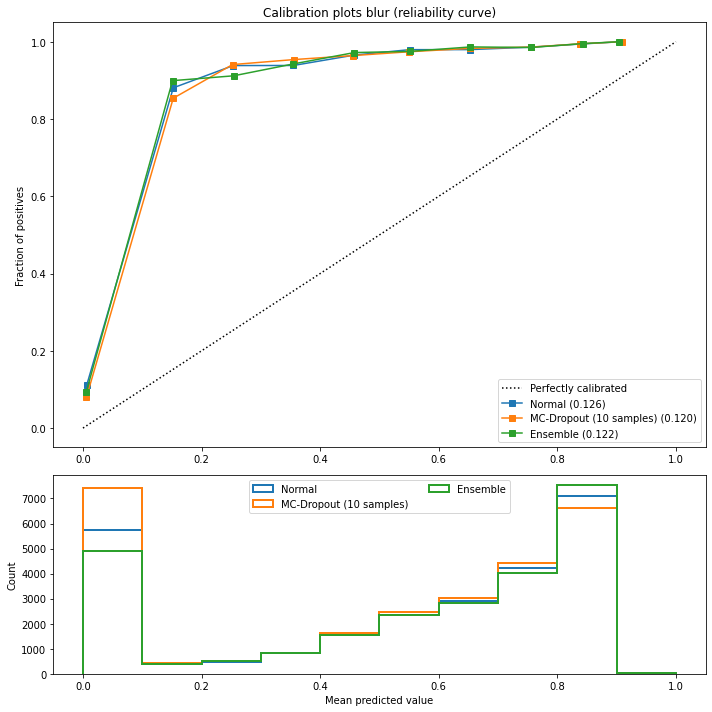

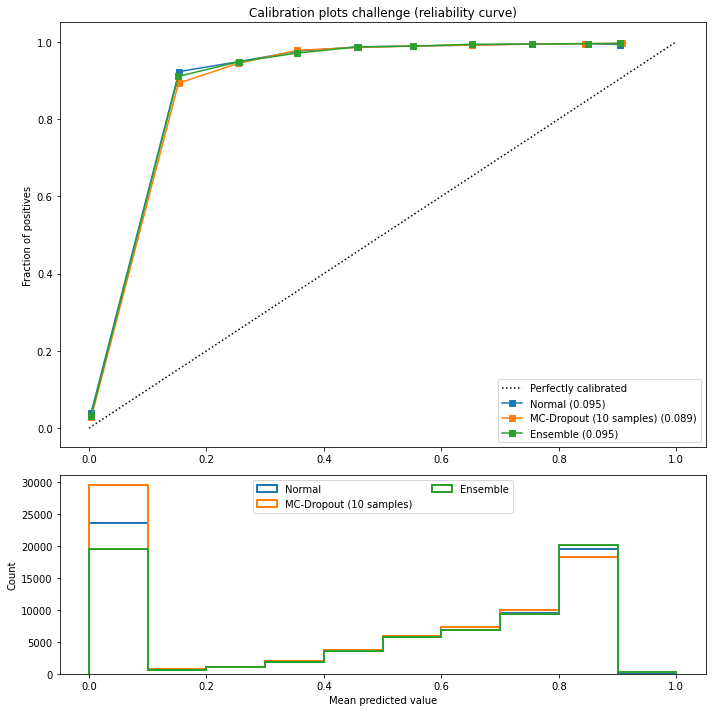

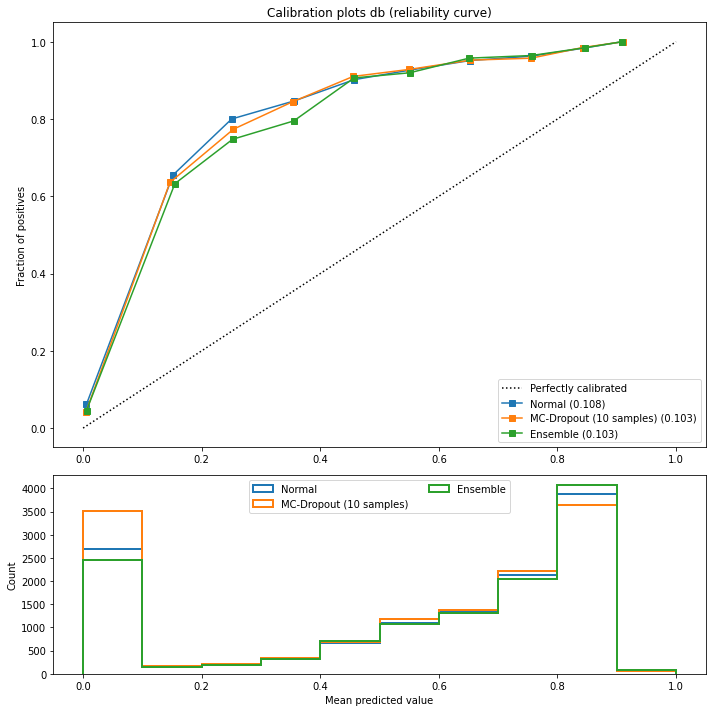

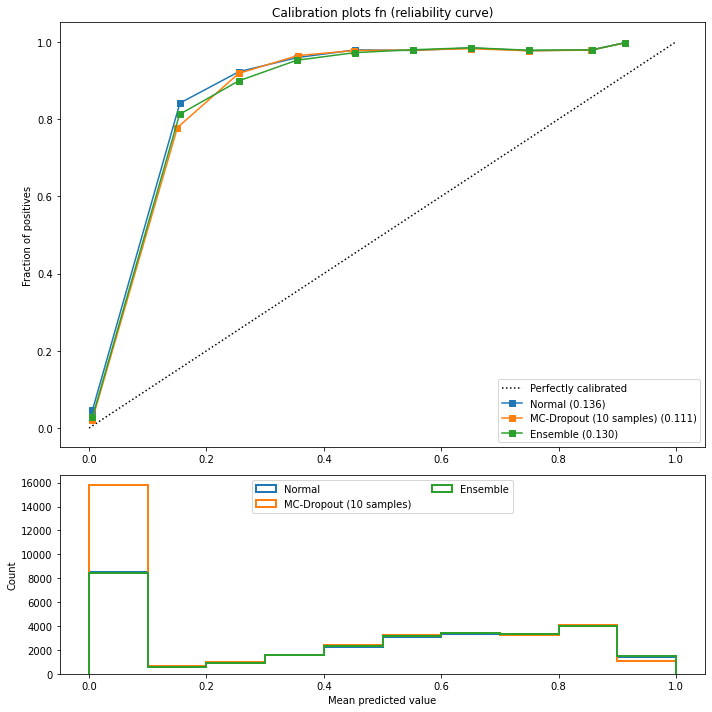

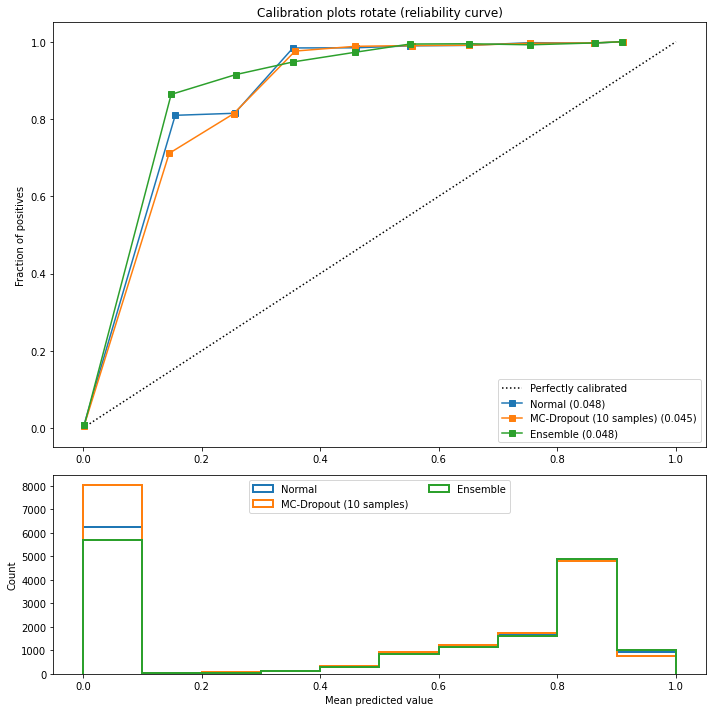

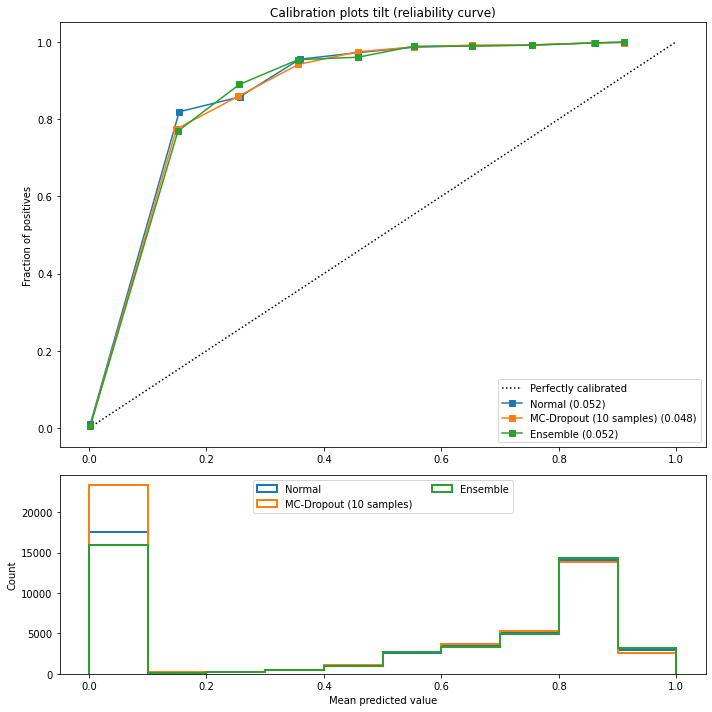

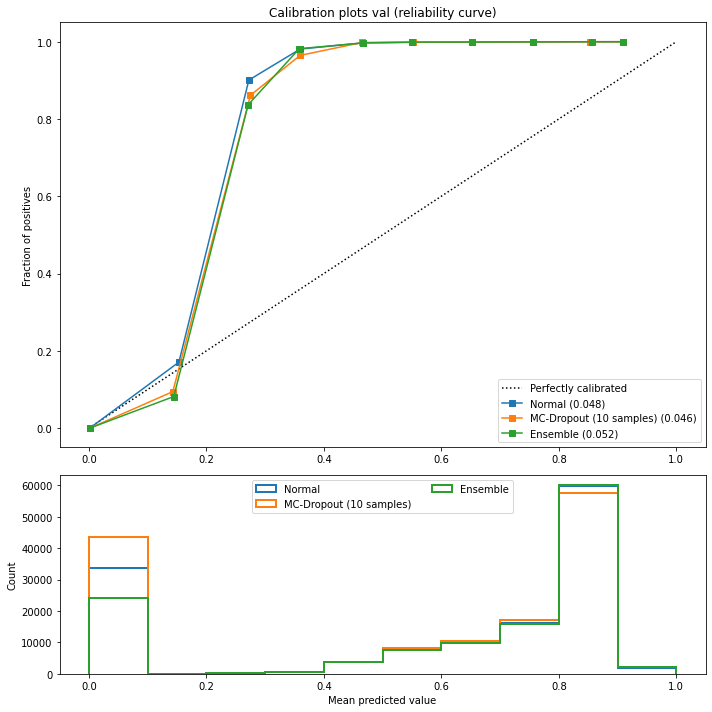

In [31]:
for i, (name, data_dict) in enumerate(zip(groups, datasets)):
    plot_calibration_curve(data_dict=data_dict, dataset_name=name, fig_index=i)

In [32]:
all_results = []
for group, data in zip(groups, datasets):
    for k, df in data.items():
        df['model'] = k
        df['dataset'] = group
        all_results.append(df)
dataset_results = pd.concat(all_results)


In [33]:
mean_results = dataset_results.groupby(by=['dataset','model']).mean()
mean_results

correct  confidence  \
dataset   model                                           
blur      Ensemble                 0.806826    0.552305   
          MC-Dropout (10 samples)  0.735134    0.493192   
          Normal                   0.784773    0.529958   
challenge Ensemble                 0.718796    0.503189   
          MC-Dropout (10 samples)  0.628275    0.432553   
          Normal                   0.681758    0.472181   
db        Ensemble                 0.769503    0.566265   
          MC-Dropout (10 samples)  0.710894    0.514252   
          Normal                   0.759336    0.552544   
fn        Ensemble                 0.698929    0.454159   
          MC-Dropout (10 samples)  0.558795    0.356370   
          Normal                   0.701195    0.450136   
rotate    Ensemble                 0.636052    0.495577   
          MC-Dropout (10 samples)  0.553442    0.426062   
          Normal                   0.615068    0.476609   
tilt      Ensemble                 0.650559    0.504435   
          MC-Dropout (10 samples)  0.560029    0.428515   
          Normal                   0.630304    0.485913   
val       Ensemble                 0.805335    0.628396   
          MC-Dropout (10 samples)  0.696002    0.539944   
          Normal                   0.747835    0.582472   

                                   bounding_box_variance   entropy  
dataset   model                                                     
blur      Ensemble                              3.301966  0.445959  
          MC-Dropout (10 samples)              53.107179  0.414573  
          Normal                                0.000000  0.436103  
challenge Ensemble                              2.041573  0.391760  
          MC-Dropout (10 samples)              47.138309  0.350353  
          Normal                                0.000000  0.372795  
db        Ensemble                              5.116936  0.436746  
          MC-Dropout (10 samples)              88.806370  0.410298  
          Normal                                0.000000  0.431445  
fn        Ensemble                              6.943384  0.408438  
          MC-Dropout (10 samples)             326.439194  0.334527  
          Normal                                0.000000  0.405921  
rotate    Ensemble                              2.386140  0.309292  
          MC-Dropout (10 samples)              92.699911  0.276798  
          Normal                                0.000000  0.301242  
tilt      Ensemble                              2.686084  0.319828  
          MC-Dropout (10 samples)             110.320862  0.282847  
          Normal                                0.000000  0.311007  
val       Ensemble                              1.373124  0.394577  
          MC-Dropout (10 samples)              66.807804  0.347908  
          Normal                                0.000000  0.368746

<AxesSubplot:ylabel='dataset,model'>

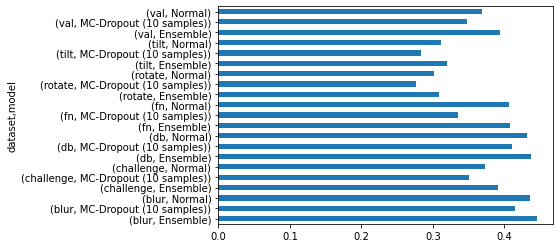

In [34]:
mean_results.entropy.plot.barh()

In [35]:
summary = pd.read_csv(ROOT/'all_test_results.csv')

In [36]:
summary

,Unnamed: 0,data,dropout,mode,mp,mr,map,mf1
0,0,ccpd_blur.data,False,ensemble,0.981640,0.954631,0.967480,0.967947
1,1,ccpd_blur.data,False,normal,0.980295,0.942652,0.966124,0.961105
2,2,ccpd_blur.data,True,dropout,0.979760,0.945854,0.966100,0.962509
3,3,ccpd_challenge.data,False,ensemble,0.990240,0.979997,0.989675,0.985092
4,4,ccpd_challenge.data,False,normal,0.990233,0.973254,0.988133,0.981670
5,5,ccpd_challenge.data,True,dropout,0.989385,0.974888,0.987924,0.982083
6,6,ccpd_db.data,False,ensemble,0.948153,0.934268,0.926514,0.941159
7,7,ccpd_db.data,False,normal,0.949644,0.926924,0.925592,0.938146
8,8,ccpd_db.data,True,dropout,0.947291,0.928050,0.924164,0.937572
9,9,ccpd_fn.data,False,ensemble,0.970165,0.963123,0.959563,0.966631
